In [2]:
import numpy as np
from tqdm import tqdm
import torch
from PIL import Image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from utils import log_ratio, visualize_reconstruction, animate_data, nll_gaussian, nll_gaussian_stable
from distmetrics.transformer import SpatioTemporalTransformer

device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_pre_imgs = 10
patch_size = 8
input_size_rnn = 8
input_size_tf = 16
num_patches = int((input_size_tf / patch_size) ** 2)

tf_config = {
    'type': 'transformer',
    'patch_size': patch_size,
    'data_dim': int(2*patch_size*patch_size),
    'num_patches': num_patches,
    "d_model": 256, # embedding dimension
    "nhead" : 4,
    "num_encoder_layers": 4,
    "dim_feedforward": 768,
    "max_seq_len": num_pre_imgs,
    "dropout": 0.2, # can be .1 - .3
    "activation": "relu"
}

In [8]:
# Landslide
target = Image.open('ValidationData/PNG_Landslide_Mask.tif')
target = ToTensor()(target)
target[target<-1] = -1
target_landslide = target[0,1248:1440,448:640] # smaller scene with landslide

landslide = torch.load('ValidationData/landslide_chip.pt')
landslide = landslide[9:20,:,:,:] # get 10 pre images + 1 post event image
landslide_logit = torch.special.logit(landslide).float()

pre_landslide = landslide_logit[:-1, :, : , :].unsqueeze(dim=0)
post_landslide = landslide_logit[-1, :, : , :].unsqueeze(dim=0)
pre_landslide = pre_landslide.to(device)


# Chile Fire
row_min = 1500
row_max = row_min+224*7
col_min = 1000
col_max = col_min+224*5

target_fire = torch.load('ValidationData/fire_mask.pt',weights_only=True)
target_fire = target_fire[row_min:row_max,col_min:col_max]

fire_data = torch.load('ValidationData/fire_val_data.pt', weights_only=True)
fire_data = fire_data[:,:,row_min:row_max,col_min:col_max]
fire_data_logit = torch.special.logit(fire_data).float()

pre_fire = fire_data_logit[:7, :, : , :].unsqueeze(dim=0).to(device) # we have 7 pre fire images
post_fire = fire_data_logit[-1, :, : , :].unsqueeze(dim=0)

# Flood
target_bangladesh = torch.load('ValidationData/bangladesh_map.pt')
target_bangladesh = target_bangladesh[1248:,1248:]

bangladesh_data = torch.load('ValidationData/bangladesh_val_data.pt')
bangladesh_data = bangladesh_data[:,:,1248:,1248:]

bangladesh_logit = torch.special.logit(bangladesh_data).float()
pre_bangladesh = bangladesh_logit[:4, :, : , :].unsqueeze(dim=0).to(device) # we only have 4 images before flooding began
post_bangladesh = bangladesh_logit[-1, :, : , :].unsqueeze(dim=0) # july 5


In [9]:
def make_preds_sliding(model, pre_imgs, chip_size=8, stride=1, flatten = True):
  '''
  pre_imgs: (Batch, Time, Channels, Height, Width) (Batch == 1)
  '''

  assert stride <= chip_size
  assert stride > 0

  data_dim_row = pre_imgs.shape[-2]
  data_dim_col = pre_imgs.shape[-1]

  assert data_dim_row % chip_size == 0
  assert data_dim_col % chip_size == 0

  pred_means = torch.zeros((1,2,data_dim_row,data_dim_col), device=pre_imgs.device)
  pred_logvars = torch.zeros_like(pred_means)
  div_mat = torch.zeros_like(pred_means)

  index_range_row = int(data_dim_row - chip_size + 1)
  index_range_col = int(data_dim_col - chip_size + 1)

  model.eval() # account for dropout, etc
  with torch.no_grad(): # tells torch it doesn't need to keep track of gradients

    for i in tqdm(range(0,index_range_row,stride)):
      for j in range(0,index_range_col,stride):

        if flatten:
          chip_mean, chip_logvar = model(pre_imgs[:,:,:,i:(i+chip_size),j:(j+chip_size)].flatten(start_dim=2))
        else:
          chip_mean, chip_logvar = model(pre_imgs[:,:,:,i:(i+chip_size),j:(j+chip_size)])

        # pred_means = torch.mean(pred_means, dim=1)
        # pred_logvars = torch.mean(pred_logvars, dim=1)
        
        pred_means[:,:,i:(i+chip_size),j:(j+chip_size)] += chip_mean.reshape((1,2,chip_size,chip_size))
        pred_logvars[:,:,i:(i+chip_size),j:(j+chip_size)] += chip_logvar.reshape((1,2,chip_size,chip_size))
        div_mat[:,:,i:(i+chip_size),j:(j+chip_size)] += 1 #count how many times we hit a certain pixel

  pred_means = pred_means / div_mat
  pred_logvars = pred_logvars / div_mat

  return pred_means, pred_logvars

# def make_preds_sliding(model, pre_imgs, chip_size=8, stride=1, flatten=True):
#     '''
#     pre_imgs: (Batch=1, Time, Channels, Height, Width)
#     '''

#     assert stride <= chip_size, "Stride must be <= chip_size"
#     assert stride > 0, "Stride must be > 0"
#     assert chip_size == model.patch_size * int(model.num_patches ** 0.5)
#     # assert chip_size == model.patch_size, f"Chip size {chip_size} must match transformer's patch size {model.patch_size}"

#     data_dim_row = pre_imgs.shape[-2]
#     data_dim_col = pre_imgs.shape[-1]

#     assert data_dim_row % chip_size == 0, "Height must be divisible by chip_size"
#     assert data_dim_col % chip_size == 0, "Width must be divisible by chip_size"

#     pred_means = torch.zeros((1, 2, data_dim_row, data_dim_col), device=pre_imgs.device)
#     pred_logvars = torch.zeros_like(pred_means)
#     div_mat = torch.zeros_like(pred_means)

#     index_range_row = int(data_dim_row - chip_size + 1)
#     index_range_col = int(data_dim_col - chip_size + 1)

#     model.eval()
#     with torch.no_grad():
#         for i in tqdm(range(0, index_range_row, stride)):
#             for j in range(0, index_range_col, stride):
#                 chip = pre_imgs[:, :, :, i:(i+chip_size), j:(j+chip_size)]

#                 if flatten:
#                     chip = chip.flatten(start_dim=2)

#                 chip_mean, chip_logvar = model(chip)

#                 # Validate shape before reshaping
#                 expected_shape = (1, 2, chip_size, chip_size)
#                 assert chip_mean.shape == expected_shape, f"Expected mean shape {expected_shape}, got {chip_mean.shape}"
#                 assert chip_logvar.shape == expected_shape, f"Expected logvar shape {expected_shape}, got {chip_logvar.shape}"

#                 # Logging a few stats for debug
#                 if i == 0 and j == 0:
#                     print(f"Sample chip_mean stats: min={chip_mean.min().item()}, max={chip_mean.max().item()}, mean={chip_mean.mean().item()}")

#                 pred_means[:, :, i:(i+chip_size), j:(j+chip_size)] += chip_mean
#                 pred_logvars[:, :, i:(i+chip_size), j:(j+chip_size)] += chip_logvar
#                 div_mat[:, :, i:(i+chip_size), j:(j+chip_size)] += 1

#     # Avoid divide-by-zero errors
#     div_mat[div_mat == 0] = 1

#     pred_means = pred_means / div_mat
#     pred_logvars = pred_logvars / div_mat

#     return pred_means, pred_logvars


In [10]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc, average_precision_score

def compute_roc(pred_map, target_map):
  '''
  Computes num_maps of binary damage maps based on input
  pred_map (ie log ratio, z-score, etc)
  '''
  assert pred_map.shape == target_map.shape

  target_map = target_map.flatten().cpu().numpy()
  pred_map = pred_map.flatten().cpu().numpy()

  precisions, recalls, thresholds = precision_recall_curve(target_map, pred_map)
  fprs, tprs, _ = roc_curve(target_map, pred_map)

  f1_scores = 2*recalls*precisions/(recalls+precisions)
  f1_scores[np.isnan(f1_scores)] = 0

  roc_auc = roc_auc_score(target_map, pred_map)

  pr_auc = average_precision_score(target_map, pred_map)

  # put metrics into a dictionary

  metrics = {'precisions': precisions,
             'recalls': recalls,
             'fprs': fprs,
             'tprs': tprs,
             'f1_scores': f1_scores,
             'thresholds': thresholds,
             'roc_auc': roc_auc,
             'pr_auc' : pr_auc}

  return metrics

def synthesize_damage_map(damage_map, num_scenes=2, method='max'):
  assert damage_map.shape[num_scenes-1] == 2
  assert num_scenes == 1 or num_scenes==2

  if method not in ['max','sum']:
    raise NotImplementedError('Method must be either max or sum')

  if method == 'max':
    return torch.max(damage_map, dim=num_scenes-1)[0]
  elif method == 'sum':
    # this is mahalanobis distance where we assume correlation (off diagonal terms) are close to 0
    if num_scenes==2:
      return torch.sqrt(damage_map[:, 0, ...]**2 + damage_map[:, 1, ...]**2)
    else:
      return torch.sqrt(damage_map[0, ...]**2 + damage_map[1, ...]**2)

def compute_damage_map(pred_mean, pred_logvar, post_img):
  assert pred_mean.shape == pred_logvar.shape
  assert pred_mean.shape == post_img.shape

  post_img = post_img.cpu()
  pred_mean = pred_mean.cpu()
  pred_logvar = pred_logvar.cpu()

  pred_std_image = torch.sqrt(torch.exp(pred_logvar))
  damage_map = torch.absolute((post_img - pred_mean) / pred_std_image)

  return damage_map


In [ ]:

transformer = SpatioTemporalTransformer(tf_config).to(device)
transformer.load_state_dict(torch.load("models/transformer_05-12-2025 12:06.pth"))
print("Number of parameters: ", transformer.num_parameters())

Number of parameters:  3261952


In [12]:
event = 'New Guinea Landslide'

if event == 'New Guinea Landslide':
  pre_imgs = pre_landslide
  post_img = post_landslide
  target_mask = target_landslide
  stride=1
  name_event = 'landslide' # for saving figs
elif event == 'Chile Fire':
  pre_imgs = pre_fire
  post_img = post_fire  
  target_mask = target_fire
  stride=4
  name_event = 'fire'
elif event == 'Bangladesh Flood':
  pre_imgs = pre_bangladesh
  post_img = post_bangladesh
  target_mask = target_bangladesh
  stride=4
  name_event = 'flood'
else:
  raise NotImplementedError

# rnn_means, rnn_logvars = make_preds_sliding(rnn, pre_imgs[:, :-1, ...], chip_size=8, stride=stride)
# tf_means, tf_logvars = make_preds_sliding(transformer, pre_imgs[:, :-1, ...], chip_size=8, flatten=False, stride=stride)
tf_means, tf_logvars = make_preds_sliding(transformer, pre_imgs[:, :-1, ...], chip_size=16, flatten=False, stride=stride)
tf_means.shape


  0%|          | 0/177 [00:00<?, ?it/s]

100%|██████████| 177/177 [00:26<00:00,  6.70it/s]


torch.Size([1, 2, 192, 192])

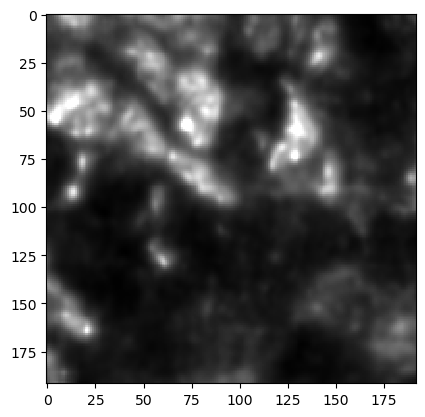

In [13]:
plt.figure()
plt.imshow(np.sqrt(np.exp(tf_logvars[0,0,...].detach().cpu().numpy())), interpolation='none', cmap='gray', vmax=.3)

# plt.show()
# plt.savefig("figs/tf_std_diagram.png", dpi=200, bbox_inches='tight', pad_inches=0)

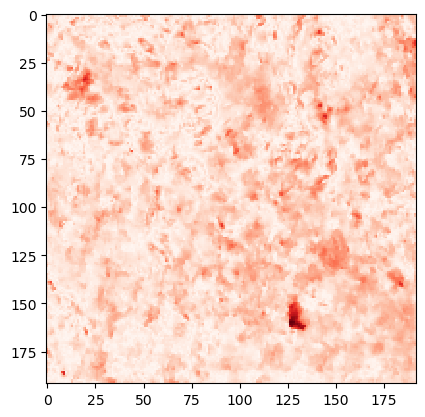

In [14]:
dam = compute_damage_map(tf_means[0,0,...], tf_logvars[0,0,...], post_landslide[0,0,...])
plt.imshow(dam, interpolation='none', cmap='Reds', vmax=8)

tensor(4.8329)
tensor(4.7684e-06)
tensor(0.3866)
tensor(0.1051)
tensor(0.3638)
tensor(0.1091)
tensor(6.0859)


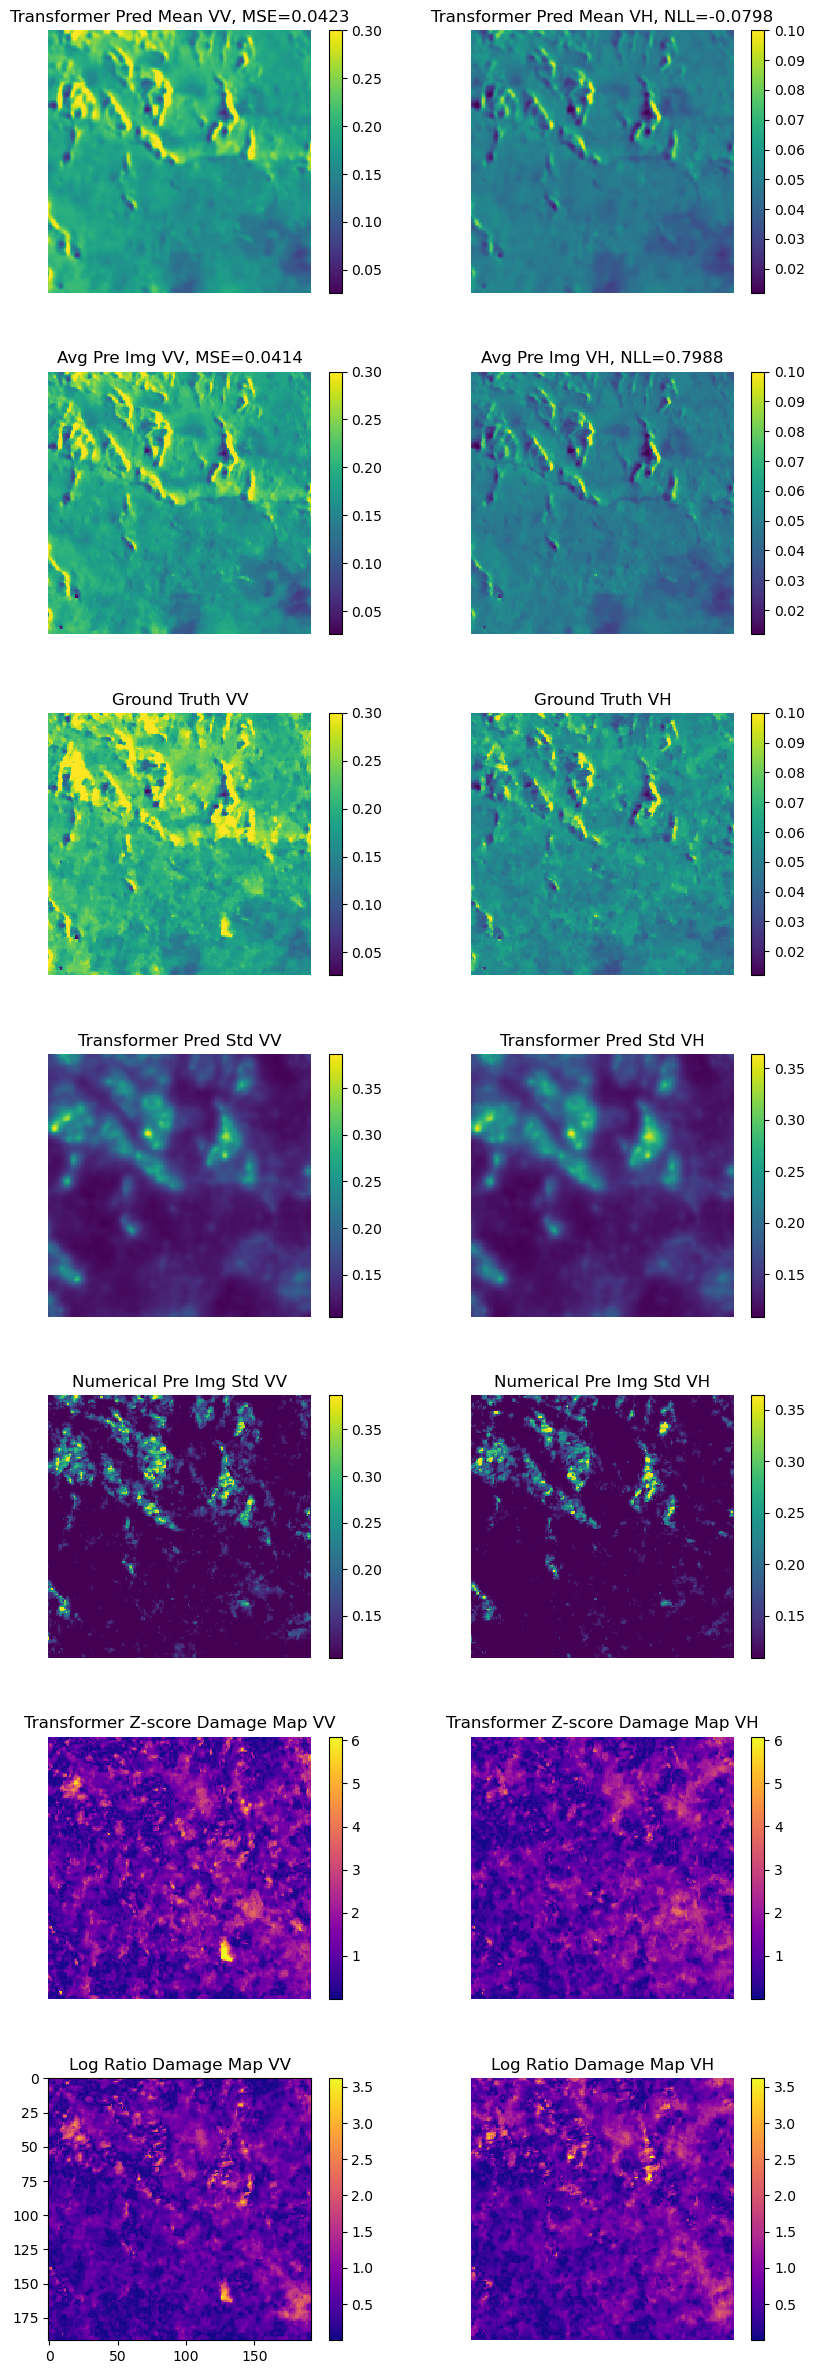

In [15]:
tf_damage_map, log_ratio_im = visualize_reconstruction(pre_imgs[0,...], post_img[0,...], tf_means[0,...], tf_logvars[0,...], 'Transformer', is_logit=True, vmax_vv=.3, vmax_vh=.1)